# Data Processing

In [1]:
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely.geometry import Point
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
trees = pd.read_csv('data/2015_Street_Tree_Census_-_Tree_Data.csv')

In [3]:
trees.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [69]:
trees = trees[trees.status == 'Alive']

In [4]:
trees.shape

(683788, 45)

In [5]:
temp = pd.read_csv('data/Hyperlocal_Temperature_Monitoring.csv')
temp.head()

,Sensor.ID,AirTemp,Day,Hour,Latitude,Longitude,Year,Install.Type,Borough,ntacode
0,Bk-BR_01,71.189000,06/15/2018,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
1,Bk-BR_01,70.243333,06/15/2018,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
2,Bk-BR_01,69.392667,06/15/2018,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
3,Bk-BR_01,68.263167,06/15/2018,4,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
4,Bk-BR_01,67.114000,06/15/2018,5,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81


In [6]:
temp.shape

(2097150, 10)

In [75]:
unique_locations = temp.groupby(['Latitude','Longitude']).count().reset_index(0).reset_index(0)[['Latitude','Longitude']]

In [76]:
unique_locations

,Latitude,Longitude
0,40.646738,-73.951234
1,40.646877,-73.946154
2,40.647370,-73.945400
3,40.647410,-73.948200
4,40.647446,-73.951205
...,...,...
430,40.883276,-73.849236
431,40.883292,-73.845751
432,40.883486,-73.847269
433,40.884042,-73.846541


In [47]:
def get_gdf(locs):
    df = gpd.GeoDataFrame({'geometry': locs}, crs='EPSG:4326')
    df = df.to_crs('EPSG:3857')
    return df

In [77]:
tree_locs = [Point(row['latitude'],row['longitude']) for _,row in trees.iterrows()]
temp_locs = [Point(row['Latitude'],row['Longitude']) for _,row in unique_locations.iterrows()]

tree_coord = get_gdf(tree_locs)
temp_coord = get_gdf(temp_locs)

In [80]:
num_trees15 = []
for i,_ in tqdm(temp_coord.iterrows(),total=temp_coord.shape[0]):
    out = tree_coord.distance(temp_coord.iloc[[i]*trees.shape[0]].reset_index(0).drop(columns='index')) / 3.2808
    num_trees15.append(sum(out<=15))

100%|██████████| 435/435 [43:37<00:00,  6.02s/it]  


In [85]:
unique_locations['num_trees_15m'] = num_trees15

In [86]:
unique_locations.to_csv('data/temp_1.csv',index=False)

In [87]:
unique_locations

,Latitude,Longitude,num_trees_15m
0,40.646738,-73.951234,3
1,40.646877,-73.946154,4
2,40.647370,-73.945400,3
3,40.647410,-73.948200,0
4,40.647446,-73.951205,2
...,...,...,...
430,40.883276,-73.849236,2
431,40.883292,-73.845751,4
432,40.883486,-73.847269,2
433,40.884042,-73.846541,8


In [240]:
temp_2 = pd.read_csv('data/temp2.csv')

In [255]:
temp_2['mean_fa_ratio'] = temp_2['mean_fa_ratio'].fillna(0)

In [256]:
unique_locations['num_build500'] = temp_2['num_build500']
unique_locations['mean_fa_ratio'] = temp_2['mean_fa_ratio']

In [89]:
days = temp.groupby(['Latitude','Longitude','Hour']).mean('AirTemp').reset_index(0).reset_index(0).reset_index(0)

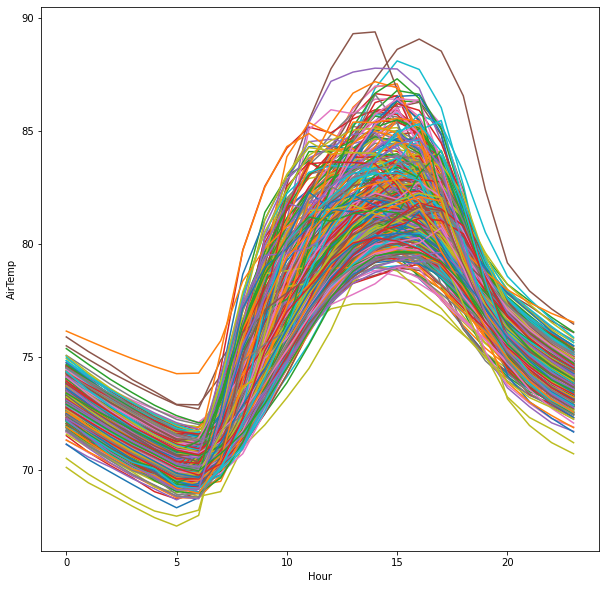

In [217]:
plt.figure(figsize=(10,10))
for i,row in unique_locations.iterrows():
    out = days[(days['Latitude'] == row["Latitude"]) & (days['Longitude'] == row["Longitude"])]
    sns.lineplot(data=out,x='Hour',y='AirTemp')

Text(0.5, 1.0, 'Number of Trees within 15m')

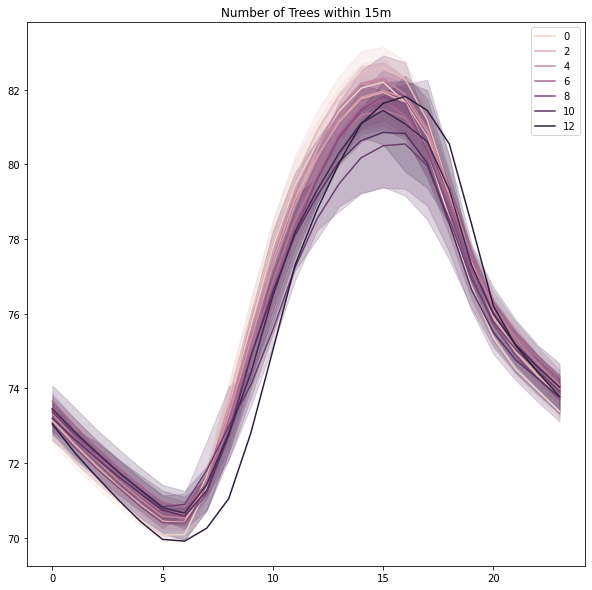

In [91]:
plt.figure(figsize=(10,10))

x,y,h = [],[],[]

for i,row in unique_locations.iterrows():
    out = days[(days['Latitude'] == row["Latitude"]) & (days['Longitude'] == row["Longitude"])]
    x.append(out['Hour'].values)
    y.append(out['AirTemp'].values)
    h.append([int(row['num_trees_15m'])] * out.shape[0])
    
ax = sns.lineplot(x=np.concatenate(x),y=np.concatenate(y),hue=np.concatenate(h))
ax.set_title('Number of Trees within 15m')

Text(0.5, 1.0, 'Number of buildings with 500m')

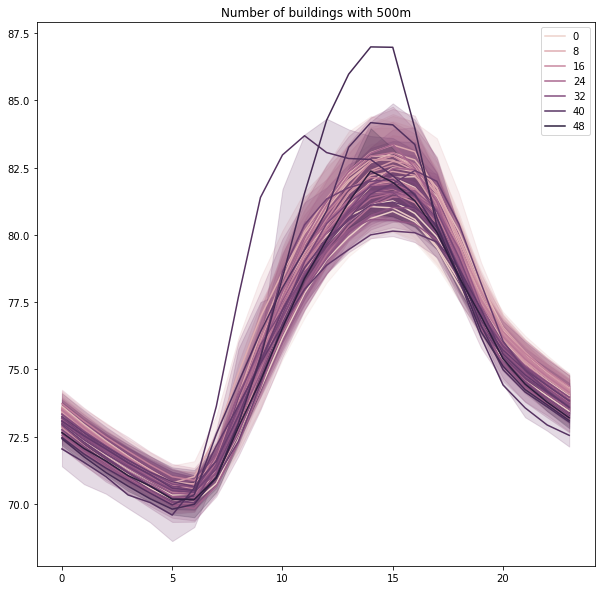

In [250]:
plt.figure(figsize=(10,10))

x,y,h = [],[],[]

for i,row in unique_locations.iterrows():
    out = days[(days['Latitude'] == row["Latitude"]) & (days['Longitude'] == row["Longitude"])]
    x.append(out['Hour'].values)
    y.append(out['AirTemp'].values)
    h.append([int(row['num_build500'])] * out.shape[0])
    
ax = sns.lineplot(x=np.concatenate(x),y=np.concatenate(y),hue=np.concatenate(h))
ax.set_title('Number of buildings with 500m')

Text(0.5, 1.0, 'Mean Floor-Area ratio with 500m')

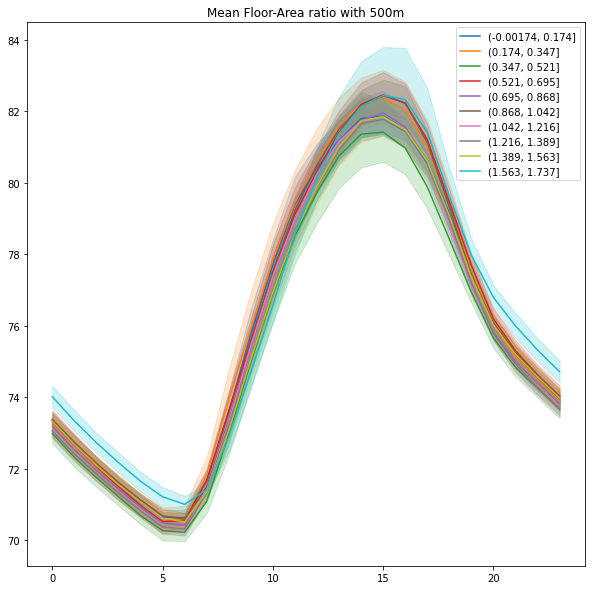

In [275]:
plt.figure(figsize=(10,10))

x,y,h = [],[],[]

for i,row in unique_locations.iterrows():
    out = days[(days['Latitude'] == row["Latitude"]) & (days['Longitude'] == row["Longitude"])]
    x.append(out['Hour'].values)
    y.append(out['AirTemp'].values)
    h.append([row['mean_fa_ratio']] * out.shape[0])
    
ax = sns.lineplot(x=np.concatenate(x),y=np.concatenate(y),hue=pd.cut(np.concatenate(h),10))
ax.set_title('Mean Floor-Area ratio with 500m')

In [70]:
cuts = pd.cut(list(range(int(temp['AirTemp'].min()),int(temp['AirTemp'].max()) + 1)),5)

In [72]:
cuts.categories

IntervalIndex([(45.932, 59.6], (59.6, 73.2], (73.2, 86.8], (86.8, 100.4], (100.4, 114.0]],
              closed='right',
              dtype='interval[float64]')

In [45]:
colors = ['#00f4ff','#00ff6a','#F8ff00','#Ffa600','#Ff0000']

In [51]:
airtemp = temp.groupby(['Latitude','Longitude','Hour']).agg({'AirTemp':np.max})

In [52]:
airtemp = airtemp.reset_index(0).reset_index(0).reset_index(0)

In [53]:
airtemp

,Hour,Longitude,Latitude,AirTemp
0,0,-73.951234,40.646738,90.495000
1,1,-73.951234,40.646738,89.385333
2,2,-73.951234,40.646738,87.939333
3,3,-73.951234,40.646738,87.133167
4,4,-73.951234,40.646738,86.572500
...,...,...,...,...
10435,19,-73.849168,40.884616,93.528167
10436,20,-73.849168,40.884616,90.682500
10437,21,-73.849168,40.884616,89.446167
10438,22,-73.849168,40.884616,88.702667


In [62]:
(int(temp['AirTemp'].max()) + 1 - int(temp['AirTemp'].min()))/5

13.8

In [286]:
Hour = 10

NYC_COORD = [40.7128, -74.0059]
map_nyc = folium.Map(location=NYC_COORD, zoom_start=12, 
tiles='cartodbpositron', width=800, height=800)
for _,row in airtemp[airtemp['Hour'] == Hour].iterrows():
    html = str(row['AirTemp'])

    iframe = folium.IFrame(html,
                           width=100,
                           height=100)

    popup = folium.Popup(ifr,ame,
                         max_width=100)

    c = 0
    for i in range(len(cuts.categories)):
        if row['AirTemp'] in cuts.categories[i]:
            c =i
    
    folium.CircleMarker(location=(row['Latitude'], row['Longitude']),color=colors[c],radius=1).add_to(map_nyc)
map_nyc

In [ ]:
interact(get_map, Hour=widgets.IntSlider(min=0, max=24, step=1))
